# Imports and Hyperparameters

In [ ]:
! pip install seaborn colour plotly

In [11]:
! python3 -m pip install --index-url https://test.pypi.org/simple/ --no-deps vaeesr   

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://test.pypi.org/simple/
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


In [10]:
! python -m pip install base_folder/dist/vaeesr-0.0.1.tar.gz

Processing ./base_folder/dist/vaeesr-0.0.1.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for vaeesr: filename=vaeesr-0.0.1-py3-none-any.whl size=16993 sha256=ade91bd137ea3a04ad9704cfd1a16df7e4b3ffcfcabfec929785daf925aa8e4f
  Stored in directory: /Users/lisa/Library/Caches/pip/wheels/76/0c/e5/e682ab93864b14664eab8d3de11e0f3164a2029bab59c7ddb2
Successfully built vaeesr
  Attempting uninstall: vaeesr
    Found existing installation: vaeesr 0.0.1
    Uninstalling vaeesr-0.0.1:
      Successfully uninstalled vaeesr-0.0.1


In [12]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.onnx
import copy

# MODEL PARAMETERS
latent_dims = 4

An increased tree depth will lead to an increased number of classes. It is important to pay attention that the dataset is still much bigger than the total number of classes.

# Helper function
Mostly for visualizations

In [13]:
def plot_losses(train_loss, test_loss, correlation_dis=None, df=None, save=None, correlations_dis_train=None, dpi=500):
    # make subplots
    fig, ax = plt.subplots(1, 3, sharex=True, figsize=(16, 5))
    fig.supxlabel('Epoch')
    fig.supylabel('Loss')

    ax[0].plot(train_loss, label='Train Loss')
    ax[0].plot(test_loss, label='Test Loss')
    ax[0].legend()
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train and Test Losses')
    #ax[0,0].suptitle('Train and Test Losses')
    if correlation_dis is not None:
        ax[1].plot(correlation_dis, label='Correlation_dis')
        if correlations_dis_train is not None:
            ax[1].plot(correlations_dis_train, label='Correlation_dis_train')
        ax[1].legend()
        ax[1].set_ylabel('Correlation')
        ax[1].set_title('Correlation between latent space representation and value distance')
        #ax[1,1].suptitle('Correlation between latent space representation and value distance')
    if df is not None:
        ax[2].plot(df['test_reconstruction_loss'], label='Reconstruction Loss')
        ax[2].plot(df['test_kl_divergence'], label='KL Loss')
        ax[2].plot(df['test_constant_loss'], label='Constant Loss')

        ax[2].plot(df['test_latent_correlation_loss'], label='Distance Correlation Loss')
        average_loss = [x/4 for x in test_loss]
        #ax[0,1].plot(average_loss, label='Total Loss / 4')
        ax[2].legend()
        ax[2].set_ylabel('Loss')
        ax[2].set_title('Individual Test Losses')
        #ax[0,1].suptitle('Individual Test Losses')
    fig.show()
    if save is not None:
        fig.savefig(save, dpi=dpi)

In [14]:
def plot_functions(equations, values, constants, is_function, is_operator):
    if len(equations) == 0:
        return None
    colors = list(Color("violet").range_to(Color("green"), len(equations)))
    try:
        fig = go.Figure(
                data=go.Scatter(
                    x=values[0][0],
                    y=values[0][1],
                    mode="lines",
                    line = dict(color = colors[0].hex,
                                            width = 4),
                    name=try_infix(equations[0], constants[0]),
                )

        )
        '''
        fig.add_trace(
            go.Bar(
                x=values[0][0],
                y=values[0][1],
                #mode="lines",
                name=try_infix(equations[0], constants[0]),
            )
        )
        '''
        for i in range(1, len(equations)):
            try:
                fig.add_trace(
                    go.Scatter(
                        x=values[i][0],
                        y=values[i][1],
                        mode="lines",
                        line = dict(color = colors[i].hex,
                                            width = 4),
                        name= try_infix(equations[i], constants[i]),
                    )
                )
            except Exception as e:
                print(f"failed to plot {equations[i]}")

        #plot(fig,filename="functions.html",auto_open=False,image='png')

    except IndexError:
        print("no functions to plot")
        fig = None
    return fig

In [15]:
def plot_dist(smpls):
    # Plot resulting probability distribution
    fig, ax = plt.subplots()

    for i in range(latent_dims):
        sns.histplot(smpls[f'latent_variable_{i}'], kde=True, ax=ax)

    # add legend
    ax.legend([f"latent_variable_{i}" for i in range(latent_dims)])

    ax.set_title("Posterior distribution of the latent variables")
    plt.show()

In [16]:
from vaeesr import decode_latent_classify, generate_values
from equation_tree.util.conversions import prefix_to_infix

def plot_sampling_functions(smpls, with_Random, latent_dims, spaces, autoencoder, dataset, classes, num_eval_samples, v_sample, v_real, v_random, target_constant, target_function, x_values):
    is_function, is_operator, is_variable, is_constant = mapping_from_spaces(spaces)
    # latent variabls values
    latent_variable_MCMC = []
    equations_MCMC = []
    constants_MCMC = []
    # generate a list of lists for the latent variables of each iteration (num_iterations, latent_dims)
    for s in range(len(smpls['latent_variable_0'])):
        embedding = []
        for i in range(latent_dims):
            embedding.append(smpls[f'latent_variable_{i}'][s].item())
        equations, constants = decode_latent_classify(autoencoder, dataset, [embedding], classes)
        values = torch.tensor(generate_values(equations[0], constants[0][0][0], is_function, is_operator, is_variable, is_constant)[1], dtype=torch.float32)
        latent_variable_MCMC += values.detach().numpy().tolist()
        constants_MCMC += [constants[0][0][0]]*num_eval_samples
        equations_MCMC += [prefix_to_infix(equations[0], is_function, is_operator).replace('x_1', 'x').replace('c_1', 'c')]*num_eval_samples

    #replace place holder with real value for constant
    #equations_MCMC = [e.replace("c_1", str(round(c, 2))) for e, c in zip(equations_MCMC, constants_MCMC)]
    df = {
        "y": latent_variable_MCMC,
        "x": x_values.tolist()*len(smpls['latent_variable_0']),
        "equation": equations_MCMC

    }

    df_compare = {
        'x': np.linspace(-1, 1, 50),
        'y_sample': v_sample[1] ,
        'y_real': v_real[1],
        'y_random': v_random[1]
    }
    print(f"the smallest constant is {min(constants_MCMC)} and the largest constant is {max(constants_MCMC)}")

    data = pd.DataFrame(df)
    #plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_compare, x='x', y='y_real', label=f"Real: {target_function.replace('c_0', str(target_constant))}", )
    #g = sns.lineplot(data=data, x='x', y='y', hue='equation', fit_reg=True, legend=False, height=5, scatter_kws={'alpha':0.5, 's': 0.05})
    sns.lineplot(data=data, x='x', y='y', hue='equation')
    #sns.lineplot(data=df_compare, x='x', y='y_sample', label=f"Sampled: {prefix_to_infix(result_equation, is_function, is_operator).replace('c_0', str(round(result_constant, 2)) )}")
    if with_Random:
        sns.lineplot(data=df_compare, x='x', y='y_random', label=f"Random: {prefix_to_infix(random_equation, is_function, is_operator).replace('c_0', str(round(random_constant, 2)) )}")

    plt.legend()

In [17]:
import plotly.graph_objects as go
def plot_interpolations(interpolated_df, assignment):
    is_function= assignment[0]
    is_operator = assignment[1]
    is_var = assignment[2]
    is_con = assignment[3]
    colors = list(Color("green").range_to(Color("blue"), len(interpolated_df.values)))
    equations = []
    equations_infix = []
    constants = []
    values = []
    for equation in interpolated_df.values:
        value = generate_values(equation[5], equation[4][0][0], is_function, is_operator, is_var, is_con)
        equation_prefix = infix_to_prefix(equation[5], is_function, is_operator,)
        if len(value) == 2:
            equations.append(equation_prefix)
            equations_infix.append(equation[5])
            constants.append(equation[4][0][0])
            values.append(value)
    if len(equations) > 0:
        print(f"{len(equations)} out of {len(interpolated_df.values)} equations were successfully evaluated")
        #print(f"The two original functions ({equations_infix[0]} and ({equations_infix[-1]})) have a correlation of {np.corrcoef(values[0][1], values[-1][1])[0][1]}, a covariance of {np.cov(values[0][1], values[-1][1])[0][1]} and a distance of {np.linalg.norm(np.array(values[0][1]) - np.array(values[-1][1], ), ord=1)/25}")
        constants_f = [[float(c)] for c in constants]
        fig = plot_functions(equations=equations, constants=constants_f, values=values, is_function=is_function, is_operator=is_operator,)

    else:
        fig = None
    return fig

# Create Dataset and Autoencoder

In [18]:
from vaeesr import create_autoencoder, create_dataset
function_space = ["sin", "exp", "cos", "tan", "abs", "sqrt", "log"]
operator_space = ["+", "-", '*', "/", "**"]
variable_space = ["x_1"]
constant_space = ["c_1", "c_0"]

spaces = (function_space, operator_space, variable_space, constant_space)

# Create dataset
train_loader, test_loader, test_size, dataset, classes, unique_symbols, max_len = create_dataset(spaces, num_equation_samples=5000, max_tree_depth=4)

# Create autoencoder
autoencoder, results = create_autoencoder(train_loader, test_loader, unique_symbols, test_size, max_len, classes, latent_dims=latent_dims)
print(f"There are a total of {len(classes)} classes")

Generate Dataset:


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:40<00:00, 123.46it/s]


preprocessing...
Train model


  0%|          | 0/500 [00:00<?, ?it/s]/Users/lisa/Library/Python/3.9/lib/python/site-packages/vaeesr/preprocessing.py:109: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:299.)
  torch.tensor(conditioning_values, dtype=torch.float),
100%|██████████| 500/500 [02:36<00:00,  3.19it/s]

There are a total of 100 classes


## Evaluate Autoencoder

### Get number of classes

In [19]:
from equation_tree.util.conversions import infix_to_prefix, prefix_to_infix
from vaeesr import mapping_from_spaces
mapping  = mapping_from_spaces(spaces)
print(f"There are a total of {len(classes)} classes")
[prefix_to_infix(dataset.decode_equation(c), mapping[0], mapping[1]) for c in classes]

There are a total of 100 classes


['(c_1+abs(x_1))',
 'sin((c_1-x_1))',
 '(sin(x_1)/c_1)',
 '(c_1*cos(x_1))',
 'sqrt((c_1**x_1))',
 '(exp(x_1)-c_1)',
 'log((c_1+x_1))',
 'sqrt((c_1-x_1))',
 'log((c_1-x_1))',
 '(c_1**tan(x_1))',
 'abs((c_1**x_1))',
 '(c_1*exp(x_1))',
 'abs((c_1/x_1))',
 'abs((c_1+x_1))',
 'tan((x_1-c_1))',
 '(cos(x_1)**c_1)',
 '(tan(x_1)/c_1)',
 'exp((x_1/4))',
 'exp((2*x_1))',
 '(c_1/tan(x_1))',
 '(c_1**x_1)',
 '(c_1-x_1)',
 '(c_1**abs(x_1))',
 '(c_1-abs(x_1))',
 'sin((x_1**2))',
 '(c_1+x_1)',
 'tan((c_1**x_1))',
 '(c_1*abs(x_1))',
 'abs((c_1*x_1))',
 'exp((x_1/2))',
 'sqrt((c_1+x_1))',
 'log((x_1**2))',
 '(c_1**sin(x_1))',
 '(c_1-sin(x_1))',
 '(c_1-tan(x_1))',
 'cos((c_1**x_1))',
 '(c_1/x_1)',
 'cos((c_1+x_1))',
 '(c_1/abs(x_1))',
 'tan((c_1*x_1))',
 '(c_1+tan(x_1))',
 '(c_1*tan(x_1))',
 'exp((x_1**2))',
 'exp((x_1/c_1))',
 '(c_1/sin(x_1))',
 'sin((c_1*x_1))',
 '(c_1**exp(x_1))',
 'tan((x_1/c_1))',
 'tan((c_1+x_1))',
 'tan((c_1-x_1))',
 'sin((c_1**x_1))',
 'cos((x_1/c_1))',
 'sin((c_1+x_1))',
 'exp((c

### Plot Loss functions and Correlation

/var/folders/jf/ydr4sg4d3bb248_vyfbfdycw0000gn/T/ipykernel_7216/970940370.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


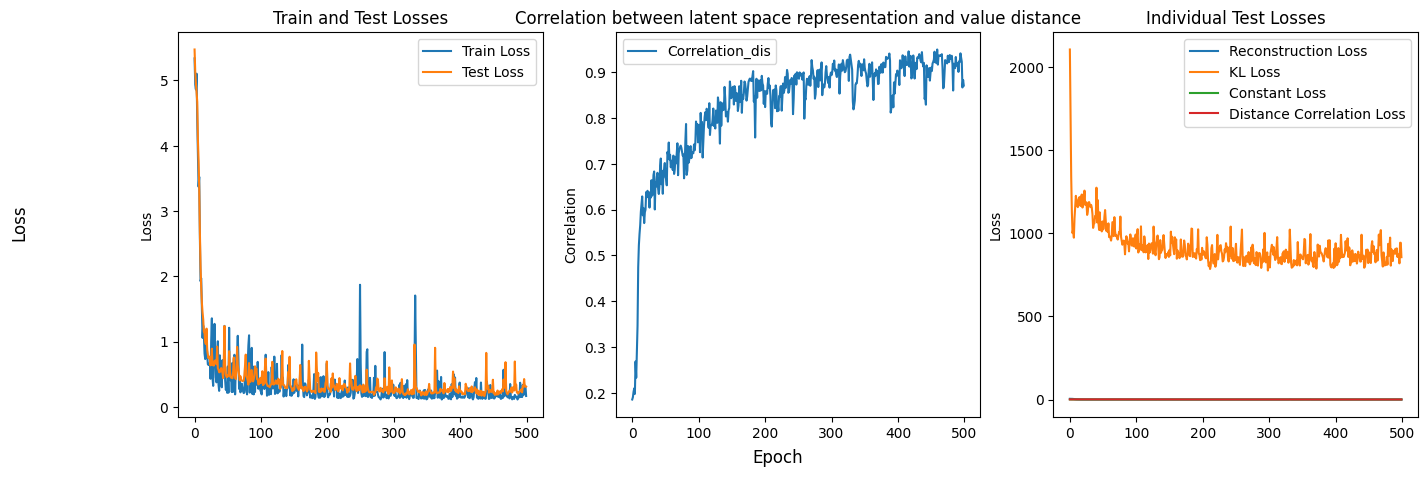

In [20]:
from vaeesr import VAE_classify
import matplotlib.pyplot as plt
#print(f"correlation distance of last epoch: {best_correlation_dis}")
#print(f"correlation correlation of last epoch: {best_correlation_cor}")
if type(autoencoder) == VAE_classify:
    df = results
else:
    df = None

plot_losses(
    results["train_losses"],
    results["test_losses"],
   correlation_dis=results["correlation_dis"],
    df = df,
)
#last_correlations_cor = np.sum(correlations_cor[-10:]) / 10
#last_correlations_dis = np.sum(correlations_dis[-10:]) / 10
#print(f"Last 10 epochs average correlation: {last_correlations_cor}")
#print(f"Last 10 epochs average correlation: {last_correlations_dis}")

### Reconstruction Accuracy

In [21]:
%reload_ext autoreload
from vaeesr import evaluation, get_latent_representation,get_interpolated_df
from equation_tree.util.conversions import prefix_to_infix

evaluation(results, dataset, max_len, classes)
#evaluation_ecv(results['x_batches'], results['x_hat_batches'], dataset, max_len, 'VAE_C')


rec: ['+', 'c_1', 'sin', 'x_1'], real: ['-', 'c_1', 'abs', 'x_1']
rec: ['-', 'exp', 'x_1', 'c_1'], real: ['-', 'cos', 'x_1', 'c_1']
rec: ['+', 'c_1', 'sin', 'x_1'], real: ['-', 'c_1', 'abs', 'x_1']
rec: ['log', '**', 'c_1', 'x_1'], real: ['*', '2', 'abs', 'x_1']


{'Equation reconstruction accuracy': 0.996, 'Number of equations': 1000}

### Minimum and Maximum Embedding Vectors

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_equations =[]
test_constants = []
for batch in test_loader:
    test_equations += batch[0]
    test_constants += batch[1]


latent_space_representation, test_values, = get_latent_representation(
    model=autoencoder,
    device=device,
    test_dataloader=test_loader,
    x_batches_p=results['x_batches'],
    x_hat_batches_p=results['x_hat_batches'],
    equation_tree_dataset=dataset,
    num_interpolations=5
)

latent_space_min_max = []
for i in range(latent_space_representation.shape[1]):
    latent_space_min_max.append((latent_space_representation[:, i].min(), latent_space_representation[:, i].max()))

print(latent_space_min_max)

[(-7.90217, 2.144982), (-5.0341244, 4.409433), (-8.540969, 7.760827), (-18.706598, 12.460129)]


### Plot Latent Space Representation

In [23]:
from equation_tree.util.conversions import prefix_to_infix

mapping = mapping_from_spaces(spaces)
df = {
    "category": [prefix_to_infix(dataset.decode_equation(eq.tolist()), mapping[0], mapping[1]).replace("c_1", str(round(float(const[0]),2))) for eq, const in zip(test_equations, test_constants)],
}

for i in range(latent_space_representation.shape[1]):
    df["x_" + str(i)] = latent_space_representation[:, i]

df = pd.DataFrame(df)

<Axes: xlabel='x_0', ylabel='x_1'>

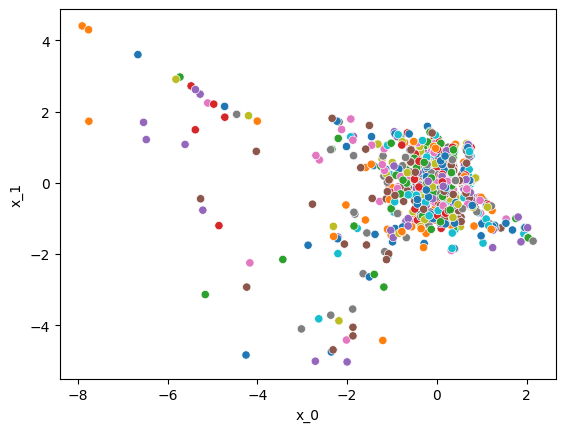

In [24]:

import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(df, x="x_0", y="x_1",hue='category', legend=False, palette="tab10")

In [25]:
from plotly.offline import plot
import plotly.express as px

fig = px.scatter_3d(
    df,
    x="x_0",
    y="x_1",
    z="x_2",
    color="category",
    title="Latent Space Representation",
    size_max=0.1,
)
plot(fig, filename="latent_space.html", auto_open=False, image="png")
fig.show()

### Plot interpolations

In [ ]:
equation_1 = 'x_1*c_1'
equation_2 = 'x_1+c_1'
df, _ = get_interpolated_df(
    kind="classifier",
    model=autoencoder,
    equation_tree_dataset=dataset,
    latent_space_representation=latent_space_representation,
    equation_1=equation_1,
    equation_2=equation_2,
    c_1=-1.0,
    c_2=1.0,
    num_interpolations=20,
    assignment=(is_function, is_operator, is_variable, is_constant),
    classes=classes,
)
if len(df.values)> 0:
    fig = plot_interpolations(df, assignment=(is_function, is_operator, is_variable, is_constant))
    fig.show()

['*', 'x_1', 'c_1', '<PAD>', '<PAD>', '<PAD>']
reconstructed euqation 1: ['-', 'exp', 'x_1', 'c_0', '<PAD>', '<PAD>'], reconstructed equation 2: ['+', 'x_1', 'c_0', '<PAD>', '<PAD>', '<PAD>']
22 out of 22 equations were successfully evaluated


In [26]:
%autoreload
from vaeesr import  generate_values, try_infix
from colour import Color

for i in range(1):
    rand_idx1 = random.randint(0, len(test_equations))
    rand_idx2 = random.randint(0, len(test_equations))
    df, _ = get_interpolated_df(
        kind="classifier",
        model=autoencoder,
        equation_tree_dataset=dataset,
        latent_space_representation=latent_space_representation,
        equation_1=rand_idx1,
        equation_2=rand_idx2,
        c_1=1.5,
        c_2=0.5,
        num_interpolations=20,
        assignment=mapping,
        classes=classes,
    )
    if len(df.values)> 0:
        fig = plot_interpolations(df, assignment=mapping)
        fig.show()


reconstructed euqation 1: ['abs', '-', 'c_1', 'x_1'], reconstructed equation 2: ['**', 'c_1', 'sin', 'x_1']
22 out of 22 equations were successfully evaluated


/Users/lisa/Library/Python/3.9/lib/python/site-packages/vaeesr/utils.py:48: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)



# MCMC sampling

In [ ]:
from vaeesr import perform_MCMC
from vaeesr import mapping_from_spaces, generate_values
import pyro
import pyro.distributions as dist
#from base_folder.vaeesr.evaluation import decode_latent_classify

mapping = mapping_from_spaces(spaces)
#target_function = "(c_0-x_1)*exp(x_1)"
#target_function = "exp(x_1)*c_0"
#target_function = "x_1+exp(x_1)+c_0"

# example function that generates the data (in practice this is the real underlying function that is unkown and only the target_dist would be available)
target_function = "c_0*x_1"
num_samples = 100
target_constant = 2.0
target_dist = generate_values(target_function, target_constant, mapping[0], mapping[1], mapping[2], mapping[3])

samples, mcmc = perform_MCMC(autoencoder, torch.tensor(target_dist, dtype=torch.float32), latent_dims, dataset, classes, spaces, num_samples=num_samples, warmup_steps=20, num_chains=2)

/usr/local/lib/python3.10/dist-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [1]:  57%|█████▊    | 69/120 [02:21,  1.06it/s, step size=2.66e-01, acc. prob=0.164]/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
Sample [1]:  58%|█████▊    | 70/120 [02:22,  1.28it/s, step size=2.66e-01, acc. prob=0.163]/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
Sample [1]: 100%|██████████| 120/120 [02:58,  1.49s/it, step size=2.66e-01, acc. prob=0.224]


## Evaluate MCMC results

### Plot resulting Functions and Distributions

In [ ]:
from equation_tree.util.conversions import infix_to_prefix, prefix_to_infix
from vaeesr import evaluate_sampling

is_function, is_operator, is_variable, is_constant = mapping_from_spaces(spaces)
v_real = generate_values(target_function, target_constant, is_function, is_operator, is_variable, is_constant)
mean_equations, sampled_equations, random_equations = evaluate_sampling(samples, autoencoder, dataset, classes, latent_dims, spaces)
print(f"resulting function: {prefix_to_infix(mean_equations[0], is_function, is_operator)} with constant {mean_equations[1]}")

resulting function: (x_1-c_1) with constant -2.0515947341918945


the smallest constant is -10.332647323608398 and the largest constant is 1.8911813497543335


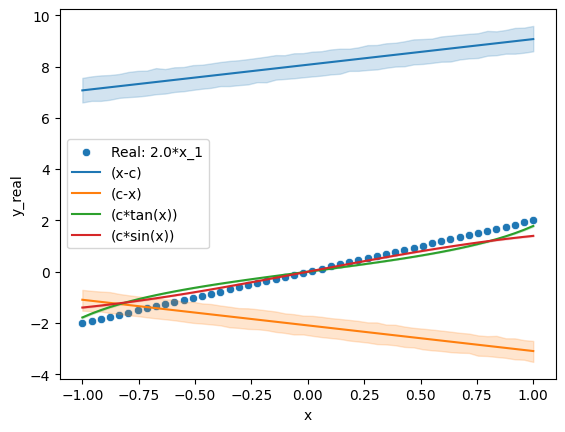

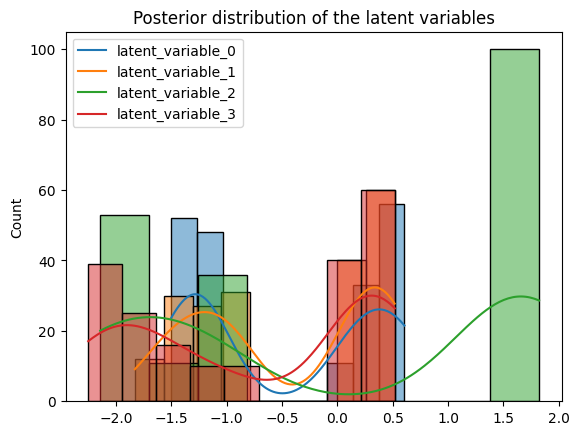

In [ ]:
#from base_folder.vaeesr.utils import plot_dist, plot_sampling_functions
import seaborn as sns
plot_sampling_functions(samples, False, latent_dims, spaces, autoencoder, dataset, classes, 50, mean_equations[2], v_real, random_equations[2], target_constant, target_function, np.linspace(-1.0, 1.0, 50))
plot_dist(samples)